In [95]:
# Parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def annihilation(d):
    return np.diag(np.sqrt(np.arange(1, d)), 1)

def creation(d):
    return annihilation(d).T

def calculate_zz(eigenvalues):
    e00 = eigenvalues[0]
    e01 = eigenvalues[1]
    e10 = eigenvalues[d2]
    e11 = eigenvalues[d2+1]
    return (e00 - e01 - e10 + e11)/2/np.pi
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
def state_index(index,dim):
    m,n,k = index
    M,N,K = dim
    return m*(N*K)+n*K+k
def floquetapp(A,omegad,omega3):
    dim = [5,5,5]
    d1 = d2 = d3 = 5
    omega1 = 5 * 2 * np.pi
    omega2 = 5.09* 2 * np.pi
    delta1 = delta2 = -0.24 * 2 * np.pi
    delta3 = -0.14 * 2 * np.pi
    g13 = g23 = 0.11 * 2 * np.pi
    g12 = -6e-3 * 2 * np.pi

    # Create operators
    a1, a2, a3 = [annihilation(d) for d in (d1, d2, d3)]
    a1d, a2d, a3d = [creation(d) for d in (d1, d2, d3)]
    I1, I2, I3 = [np.eye(d) for d in (d1, d2, d3)]

    # Construct Hamiltonians
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H2 = omega2 * a2d @ a2 + delta2/2 * a2d @ a2d @ a2 @ a2
    H3 = omega3 * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3

    H1 = np.kron(I3, np.kron(I2, H1))
    H2 = np.kron(I3, np.kron(H2, I1))
    H3 = np.kron(H3, np.kron(I2, I1))

    # Interaction terms
    Hint12 = g12 * np.kron(I3, np.kron(a2d + a2, a1d + a1))
    Hint23 = g23 * np.kron(a3d + a3, np.kron(a2d + a2, I1))
    Hint13 = g13 * np.kron(a3d + a3, np.kron(I2, a1d + a1))

    # Total Hamiltonian
    H = H1 + H2 + H3 + Hint12 + Hint23 + Hint13
    
    Hc = np.kron(a3d + a3, np.kron(I2, I1))

    # Diagonalize
    eigenvalues, _ = eigh(H)
    eigenvalues -= eigenvalues[0]
    eigenvalues,_ = sort_eigenpairs(eigenvalues,_) 
    dim = [5,5,5]
    index001 = state_index([0,0,1],dim)
    index010 = state_index([0,1,0],dim)
    index011 = state_index([0,1,1],dim)
    index100 = state_index([1,0,0],dim)
    index101 = state_index([1,0,1],dim)
    index110 = state_index([1,1,0],dim)

    
    chi12 = eigenvalues[index011]-eigenvalues[index010]-eigenvalues[index001]
    chi23 = eigenvalues[index110]-eigenvalues[index010]-eigenvalues[index100]
    chi13 = eigenvalues[index101]-eigenvalues[index001]-eigenvalues[index100]
    omega1 = eigenvalues[index001]
    omega2 = eigenvalues[index010]
    omega3 = eigenvalues[index100]
    
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H2 = omega2 * a2d @ a2 + delta2/2 * a2d @ a2d @ a2 @ a2
    H3 = (omega3-omegad) * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3
    H1 = np.kron(I3, np.kron(I2, H1))
    H2 = np.kron(I3, np.kron(H2, I1))
    H3 = np.kron(H3, np.kron(I2, I1))
    
    Hint12 = chi12 * np.kron(I3, np.kron(a2d @ a2, a1d @ a1))
    Hint23 = chi23 * np.kron(a3d @ a3, np.kron(a2d @ a2, I1))
    Hint13 = chi13 * np.kron(a3d @ a3, np.kron(I2, a1d @ a1))
    H = H1 + H2 + H3 + Hint12 + Hint23 + Hint13 + A/2*Hc
    eigenvalues, _ = eigh(H)
    eigenvalues,_ = sort_eigenpairs(eigenvalues,_) 
    eigenvalues -= eigenvalues[0]
    
    E1 = eigenvalues[index001]/2/np.pi
    E2 = eigenvalues[index010]/2/np.pi
    E3 = eigenvalues[index011]/2/np.pi
    return E1,E2,E3-E2-E1
 

In [96]:
from joblib import Parallel, delayed
def calculate_derivatives(A, omegad, omega3):
    energy001, energy010,zz = floquetapp(A, omegad, omega3)
    epsilon = 1e-6
    omega3p = omega3 + epsilon
    energy001_, energy010_, _ = floquetapp(A, omegad, omega3p)
    der1 = (energy001_ - energy001) / epsilon
    der2 = (energy010_ - energy010) / epsilon
    return der1, der2, omegad / (2 * np.pi)
def sweep_floquet_energies_derivatives(A, omega3, omega_range):
    der1_values = Parallel(n_jobs=-1)(delayed(calculate_derivatives)(A, omegad, omega3) for omegad in omega_range)
    der1_values, der2_values, omega_vals = zip(*der1_values)
    return omega_vals, der1_values, der2_values

omega3 = 3.47286432160804*2*np.pi
A = 0.005*2*np.pi
# omegad = np.linspace(3.3846*2*np.pi,3.3848*2*np.pi,1000)
omegad = np.linspace(3.37*2*np.pi,3.5*2*np.pi,300)
omega_vals, der1_values, der2_values = sweep_floquet_energies_derivatives(A, omega3, omegad)

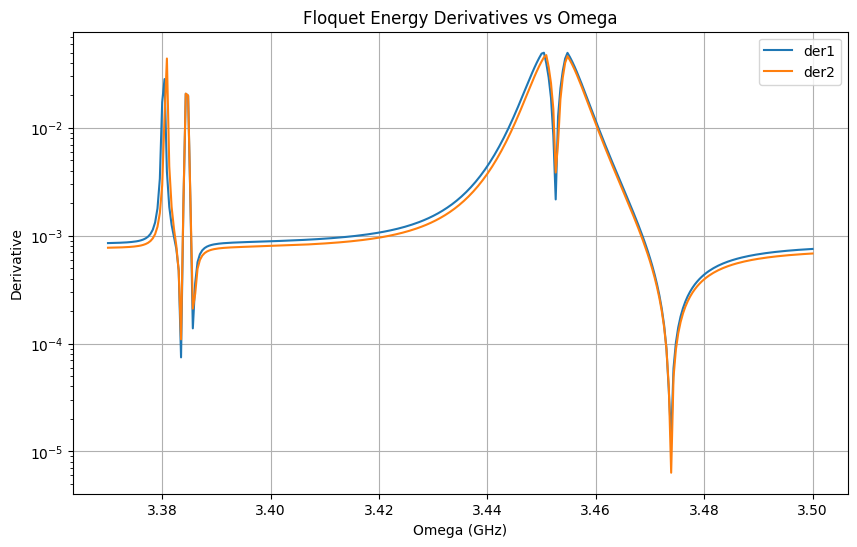

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, np.abs(der1_values), label="der1")
plt.plot(omega_vals, np.abs(der2_values), label="der2")
plt.xlabel("Omega (GHz)")
plt.ylabel("Derivative")
plt.yscale('log')
plt.title("Floquet Energy Derivatives vs Omega")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
# Parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

import sympy as sp
from sympy import eye
from sympy import symbols, Matrix
def energycor(Av,chi1cv,chi2cv,deltav,alphacv):
    omega1, omega2 , omegac,  = symbols('omega_1 omega_2 omega_c', real=True)
    alpha1, alpha2 , alphac,  = symbols('alpha_1 alpha_2 alpha_c', real=True)
    delta = symbols('delta',real = True)
    chi12, chi2c, chi1c = symbols('chi_12 chi_2c chi_1c', real=True)
    A = symbols('A', real=True)

    import qutip as qt
    E10,E01 = qt.qload('expr')
    values = {
        A: Av,        # example value
        chi1c: chi1cv,    # example value
        chi2c: chi2cv,    # example value
        delta: deltav,    # example value
        alphac: alphacv    # example value
    }

    # Substitute the values into the expression
    e01= E01.subs(values)
    e10 = E10.subs(values)
    return e01,e10

def energy(A,omegad,omega3):
    dim = [5,5,5]
    d1 = d2 = d3 = 5
    omega1 = 5 * 2 * np.pi
    omega2 = 5.09* 2 * np.pi
    delta1 = delta2 = -0.24 * 2 * np.pi
    delta3 = -0.14 * 2 * np.pi
    g13 = g23 = 0.11 * 2 * np.pi
    g12 = -6e-3 * 2 * np.pi

    # Create operators
    a1, a2, a3 = [annihilation(d) for d in (d1, d2, d3)]
    a1d, a2d, a3d = [creation(d) for d in (d1, d2, d3)]
    I1, I2, I3 = [np.eye(d) for d in (d1, d2, d3)]

    # Construct Hamiltonians
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H2 = omega2 * a2d @ a2 + delta2/2 * a2d @ a2d @ a2 @ a2
    H3 = omega3 * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3

    H1 = np.kron(I3, np.kron(I2, H1))
    H2 = np.kron(I3, np.kron(H2, I1))
    H3 = np.kron(H3, np.kron(I2, I1))

    # Interaction terms
    Hint12 = g12 * np.kron(I3, np.kron(a2d + a2, a1d + a1))
    Hint23 = g23 * np.kron(a3d + a3, np.kron(a2d + a2, I1))
    Hint13 = g13 * np.kron(a3d + a3, np.kron(I2, a1d + a1))

    # Total Hamiltonian
    H = H1 + H2 + H3 + Hint12 + Hint23 + Hint13
    
    Hc = np.kron(a3d + a3, np.kron(I2, I1))

    # Diagonalize
    eigenvalues, _ = eigh(H)
    eigenvalues -= eigenvalues[0]
    eigenvalues,_ = sort_eigenpairs(eigenvalues,_) 
    dim = [5,5,5]
    index001 = state_index([0,0,1],dim)
    index010 = state_index([0,1,0],dim)
    index011 = state_index([0,1,1],dim)
    index100 = state_index([1,0,0],dim)
    index101 = state_index([1,0,1],dim)
    index110 = state_index([1,1,0],dim)

    
    chi12 = eigenvalues[index011]-eigenvalues[index010]-eigenvalues[index001]
    chi23 = eigenvalues[index110]-eigenvalues[index010]-eigenvalues[index100]
    chi13 = eigenvalues[index101]-eigenvalues[index001]-eigenvalues[index100]
    omega1 = eigenvalues[index001]
    omega2 = eigenvalues[index010]
    omega3 = eigenvalues[index100]
    
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H2 = omega2 * a2d @ a2 + delta2/2 * a2d @ a2d @ a2 @ a2
    delta = (omega3-omegad)
    H3 = (omega3-omegad) * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3
    H1 = np.kron(I3, np.kron(I2, H1))
    H2 = np.kron(I3, np.kron(H2, I1))
    H3 = np.kron(H3, np.kron(I2, I1))
    
    Hint12 = chi12 * np.kron(I3, np.kron(a2d @ a2, a1d @ a1))
    Hint23 = chi23 * np.kron(a3d @ a3, np.kron(a2d @ a2, I1))
    Hint13 = chi13 * np.kron(a3d @ a3, np.kron(I2, a1d @ a1))
    H = H1 + H2 + H3 + Hint12 + Hint23 + Hint13 + A/2*Hc
    e01c,e10c = energycor(A,chi13,chi23,delta,delta3)
    E1 = omega1 + e01c
    E2 = omega2 + e10c
    return E1/2/np.pi,E2/2/np.pi,0
 

In [99]:
from joblib import Parallel, delayed
def calculate_derivativesapp(A, omegad, omega3):
    energy001, energy010,zz = energy(A, omegad, omega3)
    epsilon = 1e-6
    omega3p = omega3 + epsilon
    energy001_, energy010_, _ = energy(A, omegad, omega3p)
    der1 = (energy001_ - energy001) / epsilon
    der2 = (energy010_ - energy010) / epsilon
    return der1, der2, omegad / (2 * np.pi)
def sweep_floquet_energies_derivatives(A, omega3, omega_range):
    der1_values = Parallel(n_jobs=-1)(delayed(calculate_derivativesapp)(A, omegad, omega3) for omegad in omega_range)
    der1_values, der2_values, omega_vals = zip(*der1_values)
    return omega_vals, der1_values, der2_values

In [100]:
energy(0.005*2*np.pi, 3.3846*2*np.pi, 3.47286432160804*2*np.pi)

(5.00615665372159, 5.09574181510079, 0)

In [101]:
floquetapp(0.005*2*np.pi, 3.3846*2*np.pi, 3.47286432160804*2*np.pi)

(5.00627457580732, 5.095859735921233, 9.040987874264772e-05)

In [102]:
omegad

array([21.17433449, 21.1770663 , 21.17979812, 21.18252994, 21.18526176,
       21.18799358, 21.1907254 , 21.19345722, 21.19618904, 21.19892086,
       21.20165268, 21.2043845 , 21.20711632, 21.20984814, 21.21257996,
       21.21531178, 21.2180436 , 21.22077542, 21.22350724, 21.22623906,
       21.22897088, 21.2317027 , 21.23443452, 21.23716634, 21.23989816,
       21.24262998, 21.2453618 , 21.24809362, 21.25082544, 21.25355726,
       21.25628908, 21.2590209 , 21.26175272, 21.26448454, 21.26721635,
       21.26994817, 21.27267999, 21.27541181, 21.27814363, 21.28087545,
       21.28360727, 21.28633909, 21.28907091, 21.29180273, 21.29453455,
       21.29726637, 21.29999819, 21.30273001, 21.30546183, 21.30819365,
       21.31092547, 21.31365729, 21.31638911, 21.31912093, 21.32185275,
       21.32458457, 21.32731639, 21.33004821, 21.33278003, 21.33551185,
       21.33824367, 21.34097549, 21.34370731, 21.34643913, 21.34917095,
       21.35190277, 21.35463459, 21.35736641, 21.36009822, 21.36

In [116]:
omega3 = 3.47286432160804*2*np.pi
A = 0.005*2*np.pi
# omegad = np.linspace(3.3846*2*np.pi,3.3848*2*np.pi,50)
omegad = np.linspace(3.37*2*np.pi,3.5*2*np.pi,1000)
omega_vals, der1_values, der2_values = sweep_floquet_energies_derivatives(A, omega3, omegad)

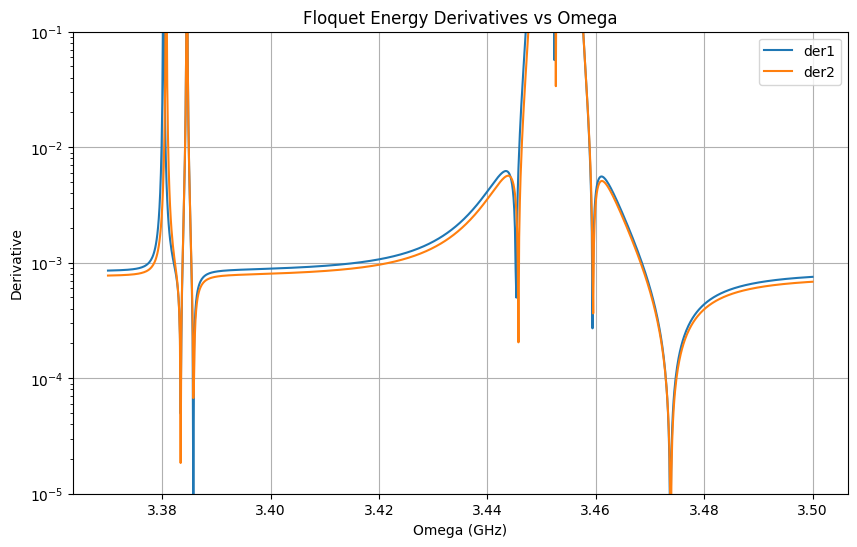

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, np.abs(der1_values), label="der1")
plt.plot(omega_vals, np.abs(der2_values), label="der2")
plt.xlabel("Omega (GHz)")
plt.ylabel("Derivative")
plt.yscale('log')
plt.title("Floquet Energy Derivatives vs Omega")
plt.ylim(1e-5,1e-1)
plt.legend()
plt.grid(True)
plt.show()

In [105]:

import sympy as sp
from sympy import eye
from sympy import symbols, Matrix
def energycor(Av,chi1cv,chi2cv,deltav,alphacv):
    omega1, omega2 , omegac,  = symbols('omega_1 omega_2 omega_c', real=True)
    alpha1, alpha2 , alphac,  = symbols('alpha_1 alpha_2 alpha_c', real=True)
    delta = symbols('delta',real = True)
    chi12, chi2c, chi1c = symbols('chi_12 chi_2c chi_1c', real=True)
    A = symbols('A', real=True)

    import qutip as qt
    E10,E01 = qt.qload('expr')
    values = {
        A: Av,        # example value
        chi1c: chi1cv,    # example value
        chi2c: chi2cv,    # example value
        delta: deltav,    # example value
        alphac: alphacv    # example value
    }

    # Substitute the values into the expression
    e01= E01.subs(values)
    e10 = E10.subs(values)
    return e01,e10

In [106]:
E10

A**4/(8*(-chi_2c - delta)**2*(-alpha_c - 2*chi_2c - 2*delta)) - A**4/(16*(-chi_2c - delta)**3) - A**4/(8*delta**2*(-alpha_c - 2*delta)) - A**4/(16*delta**3)

In [107]:
    values = {
        A: 0,        # example value
        chi1c: 0,    # example value
        chi2c: 0,    # example value
        delta: 9,    # example value
        alphac: 0    # example value
    }

# Substitute the values into the expression
result = E01.subs(values)

In [108]:
result

0